## Develop segmentation method 

In [63]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm

import skimage.segmentation as segmentation
import skimage.filters as filters
import skimage.color as color

In [12]:
# Local imports
sys.path.insert(0, 'src')
import utils
# from utils import read_json, read_lists, prepare_device
from utils import visualizations
from parse_config import ConfigParser
from data_loader import data_loaders
import model.model as module_arch

In [ ]:
# Define constants, paths
# config_path = 'configs/'

In [ ]:
# Load config file, models, and dataloader
# config_json = read_json(config_path)
# config = ConfigParser(config_json)

# device, device_ids = prepare_device(config['n_gpu'])

In [ ]:
# Load datasets

In [95]:
# Function definitions

def segment(image, method, params):
    '''
    Given an image and a segmentation method, and necessary keyword arguments, return segments

    Arg(s):
        image : C x H x W np.array   
            Image to segment
        method : str
            type of segmentation method
        params : dict
            keyword arguments for specific segmentation method
    '''

    # Assert image is in C x H x W shape
    assert len(image.shape) == 3, "Image expected to have shape C x H x W"
    assert image.shape[0] == 3, "Image expected to have 3 channels in dimension 0"
    params['channel_axis'] = 0
    
    if method == 'felzenszwalb':
        labels = segmentation.felzenszwalb(
            image,
            **params)
    elif method == 'quickshift':
        labels = segmentation.quickshift(
            image,
            **params)
    elif method == 'slic':
        labels = segmentation.slic(
            image,
            **params)
    
    elif method == 'watershed':
        del params['channel_axis']
        gradient = filters.sobel(color.rgb2gray(np.transpose(image, axes=[1, 2, 0])))
        labels = segmentation.watershed(
            gradient,
            **params)
    else:
        raise ValueError("Segmentation method {} not supported.".format(method))
    return labels

In [41]:
# Pedal to the metal!

image = utils.load_image('data/cinic-10-imagenet/train/dog/n02114712_211.png')

labels = segment(
    image=image,
    method='slic',
    params={
        'n_segments': 15,
        'channel_axis': 0}
)
# labels = np.expand_dims(labels, axis=0)


(32, 32)


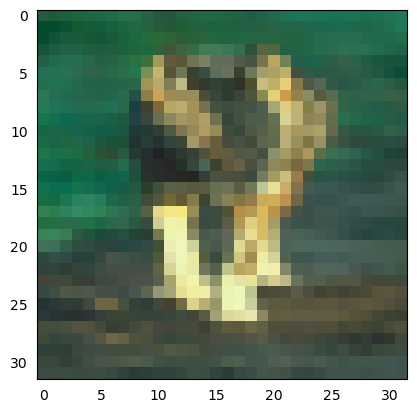

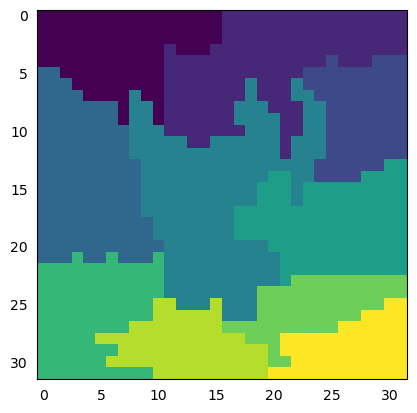

In [42]:
print(labels.shape)
# visualizations.show_image_rows(
#     images=[[image, labels]]
# )
visualizations.show_image(image)
visualizations.show_image(labels)

# Scale Up to 10 images

<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>


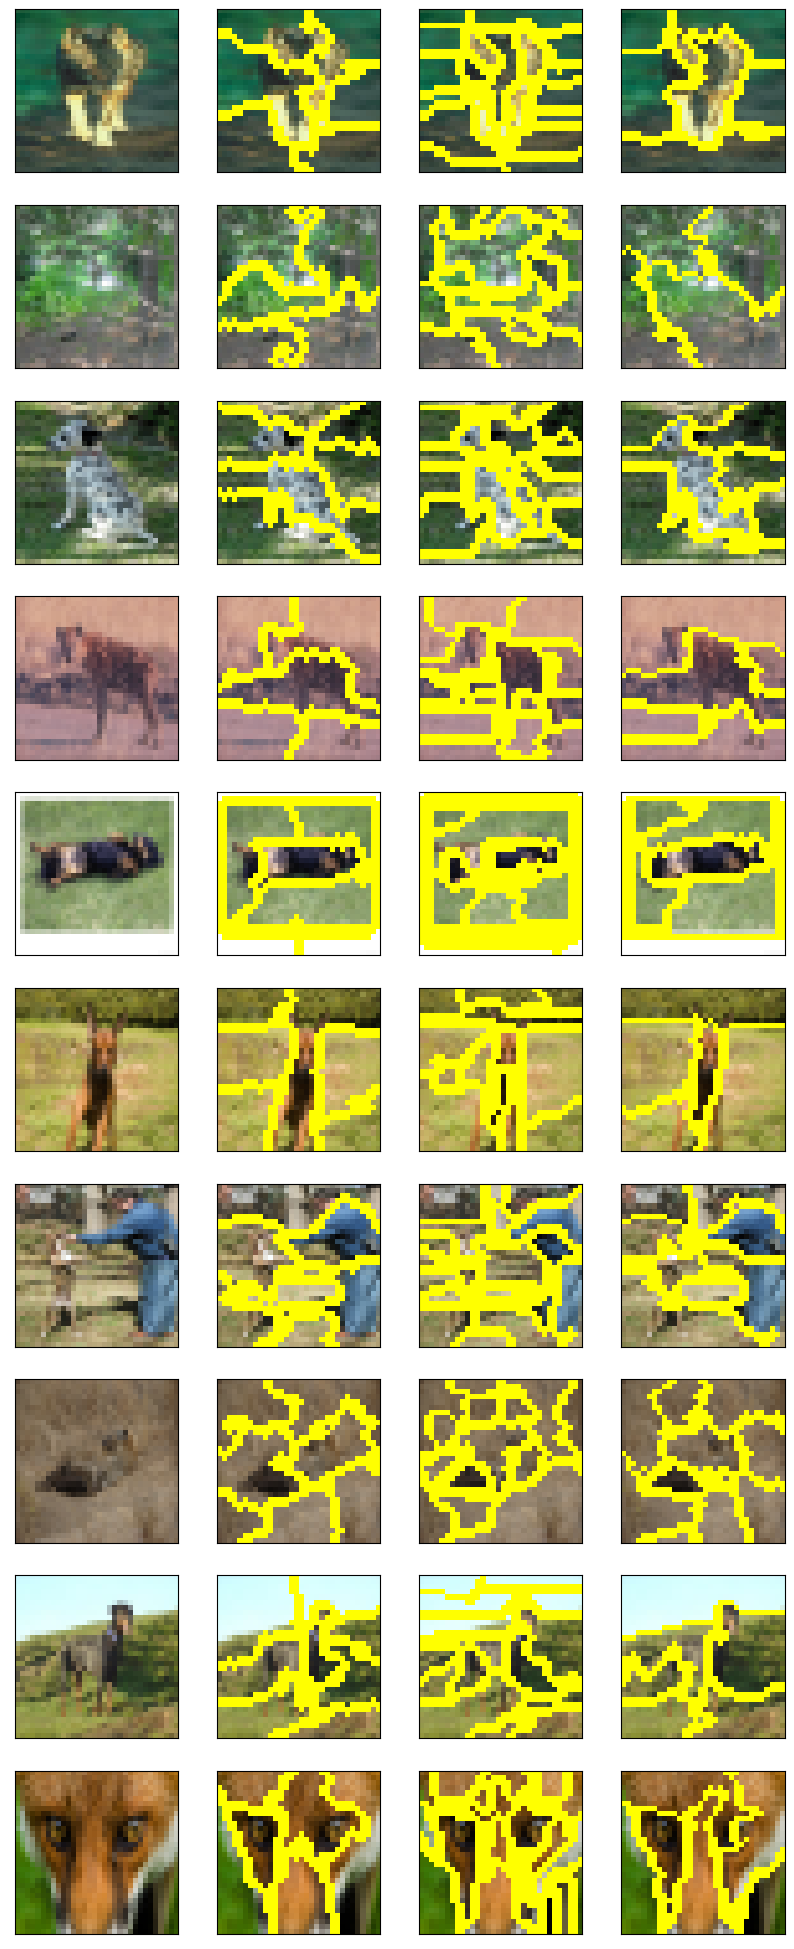

In [104]:
image_paths_path = os.path.join('paths', 'edits', 'dog', 'keys', 'key_image_paths.txt')
image_paths = utils.read_lists(image_paths_path)

felzenszwalb_params = {
    'scale': 0.9,
    'sigma': 0.25,
    'min_size': 50
}
default_quickshift_params = {
    # 'channel_axis': 0
}
quickshift_params = {
    # 'channel_axis': 0,
    'max_dist': 25,
    'kernel_size': 3,
    'sigma': 0.9,
}
slic_params = {
    'n_segments': 10,
    # 'channel_axis': 0
}

watershed_params = {
    'markers': 10,
    'watershed_line': True
}

# Create list of methods and corresponding parameters
methods = []
methods.append(('slic', slic_params))
# methods.append(('watershed', watershed_params))
# methods.append(('quickshift', default_quickshift_params))
# methods.append(('quickshift', quickshift_params))
methods.append(('felzenszwalb', {}))
methods.append(('felzenszwalb', felzenszwalb_params))
n_methods = len(methods)

images = []

for path in image_paths:
    image = utils.load_image(path)
    images.append(image)
    for method, method_params in methods:
        labels = segment(
            image,
            method=method,
            params=method_params)

        annotated_image = segmentation.mark_boundaries(np.transpose(image, axes=[1, 2, 0]), labels)
        images.append(annotated_image)

print(type(images[0]))
images = visualizations.make_grid(images, items_per_row=n_methods+1)
print(type(images))
print(type(images[0]))
print(type(images[0][0]))
visualizations.show_image_rows(images)